Data source: http://networkrepository.com/web-google-dir.php

Same graph as https://snap.stanford.edu/data/web-Google.html but with a different indexing.

In [1]:
import networkx as nx
import numpy as np
import torch
import os
import seaborn

import networkx as nx
import numpy as np

from tqdm.auto import tqdm
import pickle
import time

import numpy as np
import sys
import pickle
import seaborn as sns

%matplotlib inline

#### This notebook prepares the input data to be consumed by the Neural Network.

Run the cell below to extract the edgelist from .mtx file (the way Node2Vec expects the input). We will iterate through all the mtx files and create a corresponding .edgelist file

In [2]:
!ls ../data

com-youtube-ungraph		  web-google.7z
com-youtube-ungraph-relabel	  web-google-dir
com-youtube-ungraph-relabel_half  web-google-dir.edges
com-youtube-ungraph-relabel.txt   web-google-dir_half
com-youtube-ungraph.txt		  web-google-dir_half_noInf
emb				  web-google-dir-scc
emb_np				  web-google-dir-scc.edges
readme.html			  web-google-dir-scc_half
readme.txt			  web-google-dir-scc_half_noInf
socfb-American75.edgelist	  web-google-dir-wcc
socfb-American75.mtx		  web-google-dir-wcc.edges
socfb-OR.edgelist		  web-google-dir-wcc_half
socfb-OR.mtx			  web-google-dir-wcc_half_noInf
web-BerkStan-relabel		  web-google-dir.zip
web-BerkStan-relabel-scc	  web-google.edgelist
web-BerkStan-relabel-scc_half	  web-google.mtx
web-BerkStan-relabel-scc.txt	  web-Google.txt
web-BerkStan-relabel.txt	  web-Google.txt.gz
web-BerkStan-relabel-wcc.txt	  web-google.zip
web-BerkStan.txt


In [3]:
import os

data_files = os.listdir('../data')
for file in data_files:
    if file.endswith('.mtx'):
        file_name = file.replace('.mtx', '')
        file_edgelist = file_name+'.edgelist'
        if not file_edgelist in data_files:
            lines = None
            with open('../data/'+file) as file_mtx:
                lines = file_mtx.readlines()
            with open('../data/'+file_edgelist, 'w') as file_edgelist:
                file_edgelist.writelines(lines[2:])
                print(file_edgelist, 'created')

## Make 3 versions of the graph
+ full (already here)
+ largest wcc
+ largest scc

In [140]:
afull_g = nx.read_edgelist('../data/web-Google.txt', nodetype=int, create_using=nx.DiGraph(), comments='#')

In [143]:
max(nx.single_source_shortest_path_length(afull_g, 0).values())

32

In [142]:
max(nx.single_source_shortest_path_length(full_g, 1).values())

32

In [136]:
ds[244155 - 1]

12

In [141]:
nx.shortest_path_length(full_g, 449280, 509897)

31

In [71]:
full_g = nx.read_edgelist('../data/web-google-dir.edges', nodetype=int, create_using=nx.DiGraph(), comments='%')

In [72]:
print(len(full_g.nodes), len(full_g.edges))

875713 5105039


In [73]:
wcc = list(nx.weakly_connected_components(full_g))
scc = list(nx.strongly_connected_components(full_g))

In [74]:
wcc = sorted(wcc, key=lambda c: -len(c))
scc = sorted(scc, key=lambda c: -len(c))

In [75]:
print(len(wcc[0]))
print(len(scc[0]))

855802
434818


In [12]:
next(iter(nx.to_edgelist(full_g, nodelist=wcc[0])))

(1, 2, {})

In [76]:
with open('../data/web-google-dir-wcc.edges', 'w') as f:
    label_map = {n: rank + 1 for rank, n in enumerate(sorted(wcc[0]))}
    for i, j, _ in nx.to_edgelist(full_g, nodelist=wcc[0]):
        i = label_map[i]
        j = label_map[j]
        print(f"{i} {j}", file=f)

In [77]:
wcc_g = nx.read_edgelist('../data/web-google-dir-wcc.edges', nodetype=int, create_using=nx.DiGraph(), comments='%')

In [78]:
with open('../data/web-google-dir-scc.edges', 'w') as f:
    label_map = {n: rank + 1 for rank, n in enumerate(sorted(scc[0]))}
    for i, j, _ in nx.to_edgelist(full_g):
        if i not in scc[0] or j not in scc[0]:
            continue
        i = label_map[i]
        j = label_map[j]
        print(f"{i} {j}", file=f)

In [79]:
j

542452

In [80]:
scc_g = nx.read_edgelist('../data/web-google-dir-scc.edges', nodetype=int, create_using=nx.DiGraph(), comments='%')

In [81]:
print(len(list(nx.weakly_connected_components(wcc_g))))
print(len(list(nx.strongly_connected_components(wcc_g))))

1
355451


In [82]:
len(wcc_g.nodes)

855802

In [83]:
print(len(list(nx.weakly_connected_components(scc_g))))
print(len(list(nx.strongly_connected_components(scc_g))))

1
1


In [84]:
len(scc_g.nodes)

434818

#### Calculate landmark distances using Networkx library, instead of shitty own implementation

In [16]:
import glob

def gen_trval(graph_name, num_landmarks=(150, 50), size=(5000000, 150000), is_directed=True, folder_suffix=None, ignore_inf=False):
    if folder_suffix is None:
        folder_suffix = ''
    else:
        folder_suffix = '_' + folder_suffix
        
    os.makedirs(f'../data/{graph_name}{folder_suffix}', exist_ok=True)
    
    fs = glob.glob(f'../data/{graph_name}/landmark_distance_map_*.pickle')
    if len(fs) == 0:
        np.random.seed(999)
        edgelist_path = f'../data/{graph_name}.edges'
        graph = nx.read_edgelist(edgelist_path, nodetype=int, create_using=(nx.DiGraph() if is_directed else nx.Graph()), 
                                 comments='%')

        tr_num_lmks, te_num_lmks = num_landmarks

        nodes = list(graph.nodes)  # [int(i) for i in list(graph.nodes)]
        landmarks = np.random.choice(len(nodes), sum(num_landmarks), replace=False) + 1

        distance_map = {}
        distances = np.zeros((len(nodes), ))

        for landmark in tqdm(landmarks):
            distances[:] = np.inf
            from_lmk = dict(nx.single_source_shortest_path_length(graph, landmark))
            for key, value in from_lmk.items():
                distances[key-1] = value  # since node labels start from 1.
            from_lmk = distances.copy()

            distances[:] = np.inf
            if graph.is_directed():
                to_lmk = dict(nx.single_target_shortest_path_length(graph, landmark))
                for key, value in to_lmk.items():
                    distances[key-1] = value  # since node labels start from 1.
                to_lmk = distances.copy()
            else:
                to_lmk = None

            distance_map[landmark] = dict(
                as_source=from_lmk, as_target=to_lmk)

        save_path = f'../data/{graph_name}/landmark_distance_map_{time.time()}.pickle'
        with open(save_path, 'wb') as f:
            pickle.dump(dict(
                landmarks=landmarks,
                distance_map=distance_map,
            ), f)
        print('landmark_distance_map saved at', save_path)
    else:
        assert len(fs) == 1
        with open(fs[0], 'rb') as f:
            landmark_distance_map = pickle.load(f)
        landmarks = landmark_distance_map['landmarks']
        assert len(landmarks) == sum(num_landmarks)
        distance_map = landmark_distance_map['distance_map']
        print('landmark_distance_map loaded from', fs[0])

    fs = glob.glob(f'../data/{graph_name}/emb_np.pickle')
    if len(fs) == 0:
        emd_path = f'../data/{graph_name}/emb.emd'
        emd_map = {}
        with open(emd_path, 'r') as file:
            lines = file.readlines()
            for line in lines[1:]:
                temp = line.split(' ')
                emd_map[np.int(temp[0])] = np.array(temp[1:], dtype=np.float32)

        save_path = f'../data/{graph_name}/emb_np.pickle'
        with open(save_path, 'wb') as f:
            pickle.dump(emd_map, f)
        print('emd_map saved at', save_path)
    else:
        assert len(fs) == 1
        with open(fs[0], 'rb') as f:
            emd_map = pickle.load(f)
        print('emd_map loaded from', fs[0])
        
    print('size of emd_map:', sys.getsizeof(emd_map)/1024/1024,'MB')
    print('size of distance_map:', sys.getsizeof(distance_map)/1024/1024,'MB')
    
    def build_xyd_from_lmks(landmarks, size, seed):
        landmarks = sorted(landmarks)
        set_landmarks = set(landmarks)
        x = []
        y = []
        d = []
        for lmk in tqdm(landmarks):
            for other, dist in enumerate(distance_map[lmk]['as_source'], 1):
                if other in set_landmarks and other < lmk:
                    continue
                if ignore_inf and np.isinf(dist):
                    continue
                x.append(emd_map[lmk])
                y.append(emd_map[other])
                d.append(dist)
            if distance_map[lmk]['as_target'] is not None:
                for other, dist in enumerate(distance_map[lmk]['as_target'], 1):
                    if other in set_landmarks and other <= lmk:
                        continue
                    if ignore_inf and np.isinf(dist):
                        continue
                    x.append(emd_map[other])
                    y.append(emd_map[lmk])
                    d.append(dist)
        assert len(x) >= size
        np.random.seed(seed)
        indices = np.random.permutation(len(x))[:size]
        x = np.stack([x[i] for i in indices])
        y = np.stack([y[i] for i in indices])
        d = np.asarray([d[i] for i in indices], dtype=np.float32)
        return x, y, d

    fs = glob.glob(f'../data/{graph_name}{folder_suffix}/train_xyd.pickle')
    if len(fs) == 0 or True:
        train_xyd = build_xyd_from_lmks(landmarks[:num_landmarks[0]], size[0], seed=213)
        
        save_path = f'../data/{graph_name}{folder_suffix}/train_xyd.pickle'
        with open(save_path, 'wb') as f:
            pickle.dump(train_xyd, f)
        print('train_xyd saved at', save_path)
    else:
        assert len(fs) == 1
        with open(fs[0], 'rb') as f:
            train_xyd = pickle.load(f)
            assert train_xyd[0].shape[0] == size[0]
        print('train_xyd loaded from', fs[0])

    fs = glob.glob(f'../data/{graph_name}{folder_suffix}/test_xyd.pickle')
    if len(fs) == 0 or True:
        test_xyd = build_xyd_from_lmks(landmarks[-num_landmarks[1]:], size[1], seed=1213)
        
        save_path = f'../data/{graph_name}{folder_suffix}/test_xyd.pickle'
        with open(save_path, 'wb') as f:
            pickle.dump(test_xyd, f)
        print('test_xyd saved at', save_path)
    else:
        assert len(fs) == 1
        with open(fs[0], 'rb') as f:
            test_xyd = pickle.load(f)
            assert test_xyd[0].shape[0] == size[1]
        print('test_xyd loaded from', fs[0])
        
    return distance_map, emd_map, train_xyd, test_xyd

In [17]:
full = gen_trval('web-google-dir')

landmark_distance_map loaded from ../data/web-google-dir/landmark_distance_map_1620705686.048063.pickle
emd_map loaded from ../data/web-google-dir/emb_np.pickle
size of emd_map: 40.000091552734375 MB
size of distance_map: 0.008880615234375 MB


  0%|          | 0/150 [00:00<?, ?it/s]

train_xyd saved at ../data/web-google-dir/train_xyd.pickle


  0%|          | 0/50 [00:00<?, ?it/s]

test_xyd saved at ../data/web-google-dir/test_xyd.pickle


In [15]:
full[0].keys()

dict_keys([501444, 40364, 449280, 503610, 701916, 873900, 87483, 732392, 786757, 28880, 278604, 683932, 156922, 279496, 182034, 710070, 284198, 221315, 58702, 25737, 845423, 299870, 85443, 695150, 613799, 374118, 860586, 464129, 501063, 231854, 442747, 425251, 561186, 490989, 348720, 772496, 779705, 518070, 338779, 583031, 154485, 568810, 326073, 440443, 85584, 699296, 159280, 743750, 821819, 152218, 470257, 378582, 511659, 501157, 773799, 490310, 193093, 615895, 132998, 454707, 592736, 311006, 642623, 666079, 819245, 587398, 70094, 873225, 638035, 775658, 805844, 377143, 129446, 214205, 426221, 357460, 560305, 235303, 849697, 201496, 53559, 603901, 258342, 582135, 569619, 51081, 777464, 734433, 97533, 295288, 439273, 607550, 80658, 477812, 805999, 246500, 460571, 268375, 647151, 633854, 248368, 320012, 37097, 193716, 868237, 434376, 353614, 160546, 601414, 834015, 246393, 842264, 258257, 209654, 333315, 92183, 21855, 576610, 794411, 195008, 605649, 352571, 449099, 90336, 762972, 49868

In [23]:
d = full[0][449280]

In [18]:
d['as_target']

array([ 9.,  8.,  9., ..., 12.,  9., 10.])

<ipython-input-29-2a55c5f4856c>:1: RuntimeWarning: invalid value encountered in subtract
  diff = np.abs(d['as_source'] - d['as_target'])


<AxesSubplot:ylabel='Count'>

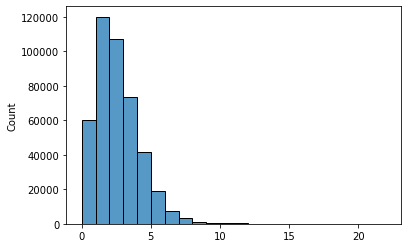

In [29]:
diff = np.abs(d['as_source'] - d['as_target'])
diff = diff[np.isfinite(diff)]
sns.histplot(diff, binwidth=1)

<AxesSubplot:ylabel='Count'>

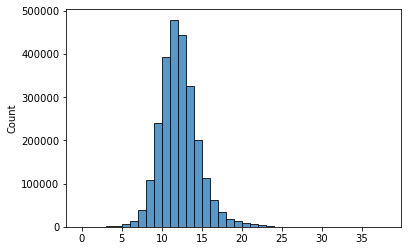

In [152]:
import seaborn as sns

train_xyd = full[-2]
sns.histplot(train_xyd[-1][np.isfinite(train_xyd[-1])], binwidth=1)

In [18]:
wcc = gen_trval('web-google-dir-wcc')

landmark_distance_map loaded from ../data/web-google-dir-wcc/landmark_distance_map_1620708195.2820244.pickle
emd_map loaded from ../data/web-google-dir-wcc/emb_np.pickle
size of emd_map: 40.000091552734375 MB
size of distance_map: 0.008880615234375 MB


  0%|          | 0/150 [00:00<?, ?it/s]

train_xyd saved at ../data/web-google-dir-wcc/train_xyd.pickle


  0%|          | 0/50 [00:00<?, ?it/s]

test_xyd saved at ../data/web-google-dir-wcc/test_xyd.pickle


<AxesSubplot:ylabel='Count'>

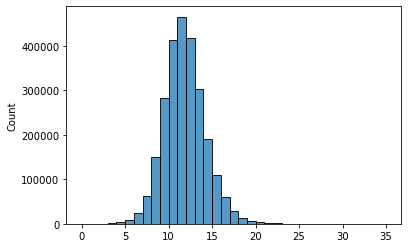

In [153]:

train_xyd = wcc[-2]
sns.histplot(train_xyd[-1][np.isfinite(train_xyd[-1])], binwidth=1)

In [19]:
scc = gen_trval('web-google-dir-scc')

landmark_distance_map loaded from ../data/web-google-dir-scc/landmark_distance_map_1620709060.7147622.pickle
emd_map loaded from ../data/web-google-dir-scc/emb_np.pickle
size of emd_map: 20.000083923339844 MB
size of distance_map: 0.008880615234375 MB


  0%|          | 0/150 [00:00<?, ?it/s]

train_xyd saved at ../data/web-google-dir-scc/train_xyd.pickle


  0%|          | 0/50 [00:00<?, ?it/s]

test_xyd saved at ../data/web-google-dir-scc/test_xyd.pickle


<AxesSubplot:ylabel='Count'>

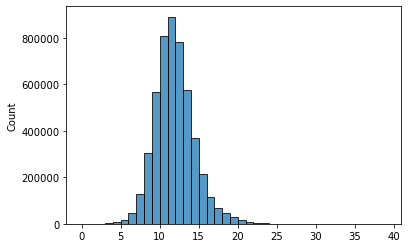

In [154]:

train_xyd = scc[-2]
sns.histplot(train_xyd[-1][np.isfinite(train_xyd[-1])], binwidth=1)

In [20]:
full_small = gen_trval('web-google-dir', size=(2500000, 150000), folder_suffix='half')

landmark_distance_map loaded from ../data/web-google-dir/landmark_distance_map_1620705686.048063.pickle
emd_map loaded from ../data/web-google-dir/emb_np.pickle
size of emd_map: 40.000091552734375 MB
size of distance_map: 0.008880615234375 MB


  0%|          | 0/150 [00:00<?, ?it/s]

train_xyd saved at ../data/web-google-dir_half/train_xyd.pickle


  0%|          | 0/50 [00:00<?, ?it/s]

test_xyd saved at ../data/web-google-dir_half/test_xyd.pickle


In [21]:
full_small_noinf = gen_trval('web-google-dir', size=(2500000, 150000), folder_suffix='half_noInf', ignore_inf=True)

landmark_distance_map loaded from ../data/web-google-dir/landmark_distance_map_1620705686.048063.pickle
emd_map loaded from ../data/web-google-dir/emb_np.pickle
size of emd_map: 40.000091552734375 MB
size of distance_map: 0.008880615234375 MB


  0%|          | 0/150 [00:00<?, ?it/s]

train_xyd saved at ../data/web-google-dir_half_noInf/train_xyd.pickle


  0%|          | 0/50 [00:00<?, ?it/s]

test_xyd saved at ../data/web-google-dir_half_noInf/test_xyd.pickle


In [22]:
wcc_small = gen_trval('web-google-dir-wcc', size=(2500000, 150000), folder_suffix='half')

landmark_distance_map loaded from ../data/web-google-dir-wcc/landmark_distance_map_1620708195.2820244.pickle
emd_map loaded from ../data/web-google-dir-wcc/emb_np.pickle
size of emd_map: 40.000091552734375 MB
size of distance_map: 0.008880615234375 MB


  0%|          | 0/150 [00:00<?, ?it/s]

train_xyd saved at ../data/web-google-dir-wcc_half/train_xyd.pickle


  0%|          | 0/50 [00:00<?, ?it/s]

test_xyd saved at ../data/web-google-dir-wcc_half/test_xyd.pickle


In [23]:
wcc_small_noinf = gen_trval('web-google-dir-wcc', size=(2500000, 150000), folder_suffix='half_noInf', ignore_inf=True)

landmark_distance_map loaded from ../data/web-google-dir-wcc/landmark_distance_map_1620708195.2820244.pickle
emd_map loaded from ../data/web-google-dir-wcc/emb_np.pickle
size of emd_map: 40.000091552734375 MB
size of distance_map: 0.008880615234375 MB


  0%|          | 0/150 [00:00<?, ?it/s]

train_xyd saved at ../data/web-google-dir-wcc_half_noInf/train_xyd.pickle


  0%|          | 0/50 [00:00<?, ?it/s]

test_xyd saved at ../data/web-google-dir-wcc_half_noInf/test_xyd.pickle


In [24]:
scc_small = gen_trval('web-google-dir-scc', size=(2500000, 150000), folder_suffix='half')

landmark_distance_map loaded from ../data/web-google-dir-scc/landmark_distance_map_1620709060.7147622.pickle
emd_map loaded from ../data/web-google-dir-scc/emb_np.pickle
size of emd_map: 20.000083923339844 MB
size of distance_map: 0.008880615234375 MB


  0%|          | 0/150 [00:00<?, ?it/s]

train_xyd saved at ../data/web-google-dir-scc_half/train_xyd.pickle


  0%|          | 0/50 [00:00<?, ?it/s]

test_xyd saved at ../data/web-google-dir-scc_half/test_xyd.pickle


In [43]:
import matplotlib.pyplot as plt

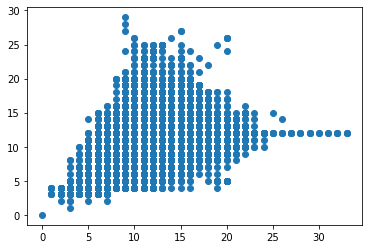

In [44]:
plt.scatter(scc_small[0][377939]['as_source'], scc_small[0][377939]['as_target'])

In [25]:
scc_small_noinf = gen_trval('web-google-dir-scc', size=(2500000, 150000), folder_suffix='half_noInf', ignore_inf=True)

landmark_distance_map loaded from ../data/web-google-dir-scc/landmark_distance_map_1620709060.7147622.pickle
emd_map loaded from ../data/web-google-dir-scc/emb_np.pickle
size of emd_map: 20.000083923339844 MB
size of distance_map: 0.008880615234375 MB


  0%|          | 0/150 [00:00<?, ?it/s]

train_xyd saved at ../data/web-google-dir-scc_half_noInf/train_xyd.pickle


  0%|          | 0/50 [00:00<?, ?it/s]

test_xyd saved at ../data/web-google-dir-scc_half_noInf/test_xyd.pickle


In [30]:
from sklearn.preprocessing import MinMaxScaler
import pickle
from sklearn.preprocessing import StandardScaler

# TODO try standardization and no normalization also and compare result

scaler = StandardScaler()
# scaler = MinMaxScaler(feature_range=(0, 1))
x_train = scaler.fit_transform(x_train)
x_cv = scaler.transform(x_cv)
x_test = scaler.transform(x_test)

pickle.dump((x_train, y_train), open('../outputs/train_xy_no_sampling_stdScale.pk', 'wb'))
pickle.dump((x_cv, y_cv), open('../outputs/val_xy_no_sampling_stdScale.pk', 'wb'))
pickle.dump((x_test, y_test), open('../outputs/test_xy_no_sampling_stdScale.pk', 'wb'))